<a href="https://colab.research.google.com/github/Kaidavid/CS492A_Courseworks/blob/master/Coursework1_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Coursework 1**
<ul>
  <li><a href="https://docs.google.com/document/d/1PLhwSVKv-7n4OdWUSZwEho1bMf65Kq_qqImyyVKJXO4/edit?usp=*sharing*">Google Doc Link</a></li>
  <li>Team
    <ul>
      <li><strong>Melka Dawit</strong> - 20180754</li>
      <li><strong>Shigutie Mintesinot</strong> - 20180954</li>
    </ul>
  </li>
</ul>

In [ ]:
import numpy as np
import pandas as pd
import scipy.io
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from platform import python_version
print('python', python_version())

python 3.7.12


In [ ]:
from google.colab import drive

drive.mount('/gdrive')
# Specify the directory path where `Coursework_1.ipynb` exists.
# then set root = '/gdrive/My Drive/CS492A'

root = '/gdrive/My Drive/CS492A'
#!ls /gdrive/MyDrive/CS492A

Mounted at /gdrive


In [ ]:
mat = scipy.io.loadmat(root + '/face.mat')
X = list(mat.values())[3]
Y = list(mat.values())[4]

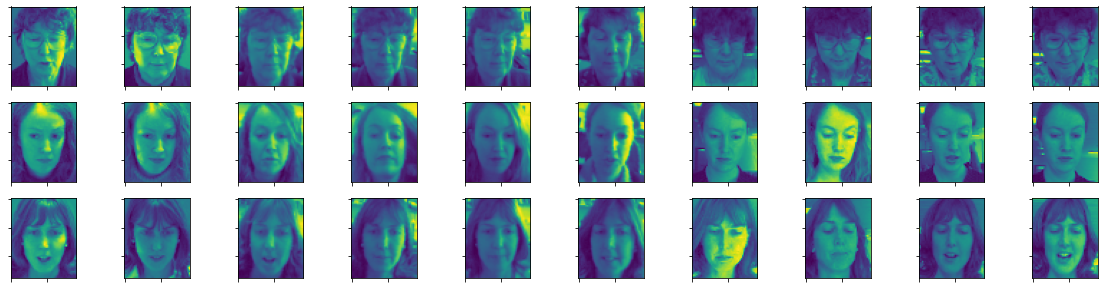

In [ ]:
### 10 different face images of each of 3 distinct identities
_ , axes = plt.subplots(3, 10, figsize=(20, 5))
for i, ax in enumerate(axes.flat):
  ax.imshow(X[:, i].reshape(46, 56).T)
  ax.set_yticklabels([])
  ax.set_xticklabels([])

###**PCA Analysis**###

In [ ]:
train_size = 8
test_size = 10 - train_size
X_train = np.zeros((2576, train_size * 52), dtype=np.uint8)   #8 columns for training
X_test = np.zeros((2576, test_size * 52), dtype=np.uint8)    #2 columns for testing
X_shuffle = np.zeros((2576, 520), dtype=np.uint8) #same as face data but shuffled for training
index_train, index_test = 0, 0
zero_centered = True
rand_col = np.random.choice(range(10), train_size, replace=False).tolist()
rand_col.sort()
for i in range(0, 520, 10):
  pick_train_col = [X[:, i+x] for x in range(train_size)] #rand_col or range(8)
  pick_test_col = [X[:, i+x] for x in range(train_size, 10)] #range(10) if (x not in rand_col) or range(8, 10)
  X_train[:, index_train:index_train + train_size] = np.array(pick_train_col).T
  X_test[:, index_test:index_test + test_size] = np.array(pick_test_col).T
  X_shuffle[:, index_train + index_test:index_train + index_test + 10] = np.hstack((np.array(pick_train_col).T, np.array(pick_test_col).T))
  index_train += train_size
  index_test += test_size

n_dim, n_samples = X_train.shape[0], X_train.shape[1]
X_mean = np.mean(X_train, axis=1, dtype=np.float64)
A = X_train - X_mean.reshape((n_dim,1)) if zero_centered else X_train   #zero_centering
print("Image {} of each identity will be used for testing.". format([x+1 for x in range(10) if (x not in rand_col)]))

Image [7, 10] of each identity will be used for testing.


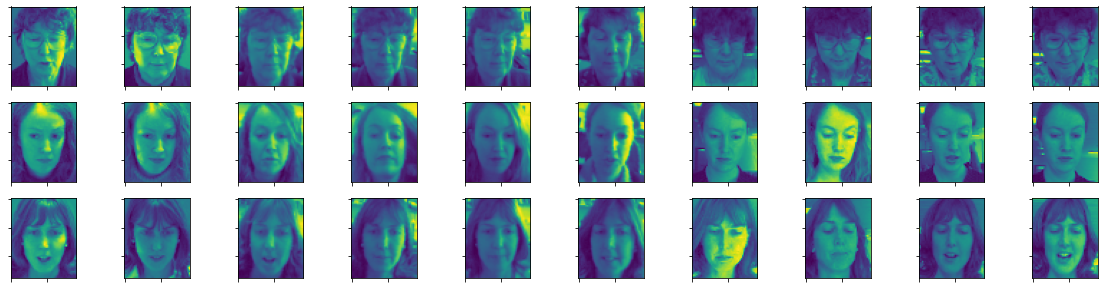

In [ ]:
### Train images | Test images
_ , axes = plt.subplots(3, 10, figsize=(20, 5))
for i, ax in enumerate(axes.flat):
  ax.imshow(X_shuffle[:, i].reshape(46, 56).T)
  ax.set_yticklabels([])
  ax.set_xticklabels([])

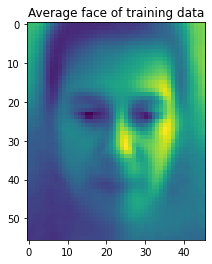

In [ ]:
plt.title("Average face of training data")
plt.imshow(X_mean.reshape(46, 56).T)

####**PCA**####

In [ ]:
t0 = time.time()
cov_matrix_high = (1/n_samples) * np.dot(A, A.T)    #covariance matrix high dimensionality
eigenvectors_high, eigenvalues_high, _ = np.linalg.svd(cov_matrix_high, full_matrices=True)
t1 = time.time()
print("High-D execution time: ", t1 - t0)
print("High-D Rank: ", np.linalg.matrix_rank(cov_matrix_high))
print(f"High-D Shape of eigenvectors: {eigenvectors_high.shape}, Shape of eigenvalues: {eigenvalues_high.shape}")

t0 = time.time()
cov_matrix_low = (1/n_samples) * np.dot(A.T, A)     #covariance matrix low dimensionality
eigenvectors_low, eigenvalues_low, _ = np.linalg.svd(cov_matrix_low, full_matrices=True)
t1 = time.time()
print("Low-D execution time: ", t1 - t0)
print("Low-D Rank: ", np.linalg.matrix_rank(cov_matrix_low))
print(f"Low-D Shape of eigenvectors: {eigenvectors_low.shape}, Shape of eigenvalues: {eigenvalues_low.shape}")

High-D execution time:  11.643583059310913
High-D Rank:  415
High-D Shape of eigenvectors: (2576, 2576), Shape of eigenvalues: (2576,)
Low-D execution time:  0.0917658805847168
Low-D Rank:  415
Low-D Shape of eigenvectors: (416, 416), Shape of eigenvalues: (416,)


In [ ]:
non_zero_eigenvalues_high = [x for x in eigenvalues_high if round(x,4) > 0]
non_zero_eigenvalues_low = [x for x in eigenvalues_low if round(x,4) > 0]
print("High-D: {} Non-zero eigenvalues and {} zero eigenvalues".format(len(non_zero_eigenvalues_high), 2576 - len(non_zero_eigenvalues_high)))
print("Low-D: {} Non-zero eigenvalues and {} zero eignevalues ".format(len(non_zero_eigenvalues_low), train_size*52 - len(non_zero_eigenvalues_low)))

High-D: 415 Non-zero eigenvalues and 2161 zero eigenvalues
Low-D: 415 Non-zero eigenvalues and 1 zero eignevalues 


In [ ]:
### Visualize the decrease in the eigenvalue
fig1 = go.Figure()
fig1.add_trace(go.Scatter(y=non_zero_eigenvalues_high,
                    mode='lines',
                    name='High-D'))
fig1.add_trace(go.Scatter(y=non_zero_eigenvalues_low,
                    mode='lines',
                    name='Low-D'))
fig1.update_layout(xaxis_title="Number of eigenvectors with non-zero eigenvalues",
                   yaxis_title="Eigenvalue",
                   width=1100,
                   height=550)
fig1.show()

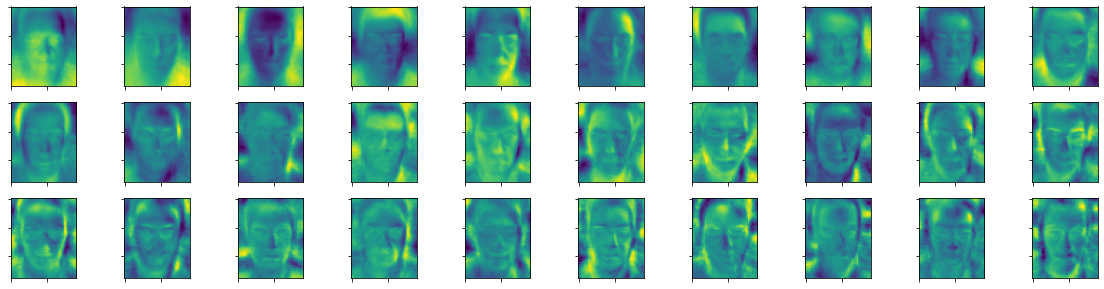

In [ ]:
### Top 30 Eigenfaces of high-D
_ , axes = plt.subplots(3, 10, figsize=(20, 5))
for i, ax in enumerate(axes.flat):
  ax.imshow(eigenvectors_high[:, i].reshape(46, 56).T)
  ax.set_yticklabels([])
  ax.set_xticklabels([])

**Get High-D eigenvectors form Low-D eigenvectors**

In [ ]:
eigenvectors_calculated_from_low = np.dot(A, eigenvectors_low)[:, :-1] #(2576, 415)  U = AV   remove the last vector that gives 0 eigenvalue
eigenvectors_calculated_from_low /= np.array([np.linalg.norm(x) for x in eigenvectors_calculated_from_low.T])   #normalize the vectors
eigenvectors_from_high = eigenvectors_high[:, :len(non_zero_eigenvalues_high)]   #the ones with non-zero eigenvalue

**Check if eigenvectors obtained from Low-D are identical to eigenvectors of High-D**

In [ ]:
compare_eigenvectors = np.round(eigenvectors_calculated_from_low - eigenvectors_from_high, decimals=4)
temp = np.copy(eigenvectors_calculated_from_low)

In [ ]:
arr_1 = np.sum(compare_eigenvectors, axis=0)
print("Number of nonidentical eigenvectors: ",np.count_nonzero(arr_1))
for i in range(compare_eigenvectors.shape[1]):
  if arr_1[i] != float(0):
    temp[:, i] = np.negative(eigenvectors_calculated_from_low[:, i])    # negate the vector == flip its direction

Number of nonidentical eigenvectors:  210


In [ ]:
compare_eigenvectors_after_flip = np.round(temp - eigenvectors_from_high, decimals=4)
arr_2 = np.sum(compare_eigenvectors_after_flip, axis=0)
print("Number of nonidentical eigenvectors: ", np.count_nonzero(arr_2))

Number of nonidentical eigenvectors:  0


**Working with Top M eigenvectors and Reconstruction**

In [ ]:
M = 3
reconstructed_images = np.zeros(X_train.shape)
top_eigenvectors = eigenvectors_calculated_from_low[:, :M]  #DxM
projection_coeff = np.dot(A.T, top_eigenvectors)  #NxM each row is coefficient of projection of each image in to the space spanned by the top eigenvectors
for i in range(n_samples):
  projected = np.multiply(projection_coeff[i, :], top_eigenvectors)   #a1u1, a2u2, ...
  reconstructed_images[:, i] = X_mean + np.sum(projected, axis=1)   #x_mean + a1u1 + a2u2

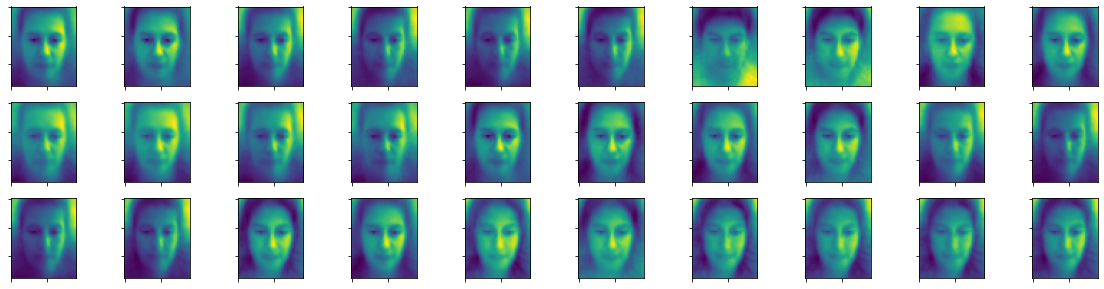

In [ ]:
### 30 Reconstructed of high-D
_ , axes = plt.subplots(3, 10, figsize=(20, 5))
for i, ax in enumerate(axes.flat):
  ax.imshow(reconstructed_images[:, i].reshape(46, 56).T)
  ax.set_yticklabels([])
  ax.set_xticklabels([])

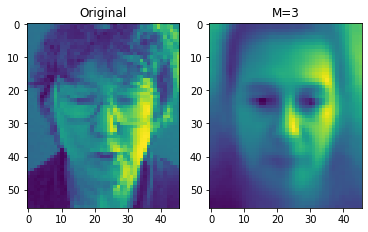

In [ ]:
## Sample Reconstruction
fig1 = plt.figure()
img1 = fig1.add_subplot(1, 2, 1)
plt.title("Original")
img1.imshow(X_train[:, 0].reshape(46, 56).T)
img2 = fig1.add_subplot(1, 2, 2)
plt.title("M=" + str(M))
img2.imshow(reconstructed_images[:, 0].reshape(46, 56).T)


In [ ]:
if M == 3:
  df = pd.DataFrame(projection_coeff, columns=["x", "y", "z"])
  df["label"] = 0
  j = 1
  for i in range(0, n_samples, train_size):
    df.iloc[i:i+train_size, 3] = j
    j += 1
  sample_images = 5
  fig = px.scatter_3d(df.iloc[:sample_images * train_size, :], x='x', y='y', z='z', color='label', opacity=0.7, template='plotly_dark', title="First " + str(sample_images) + " identites", size_max=0.5, width=1000, height=600)
  fig.update_traces(marker_coloraxis=None)
  fig.show()

### **KNN**

In [ ]:
## Accuracy measurement with M eigenvectors
projected_train_df = pd.DataFrame(projection_coeff)
projected_train_df["label"] = 0
label = 1
for i in range(0, n_samples, train_size):
  projected_train_df.iloc[i:i+train_size, -1] = label
  label += 1

projected_test_df = pd.DataFrame(np.dot((X_test - X_mean.reshape((n_dim,1))).T, top_eigenvectors)) #104xM
projected_test_df["label"] = 0
label = 1
for i in range(0, test_size * 52, test_size):
  projected_test_df.iloc[i:i+train_size, -1] = label
  label += 1

classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(projected_train_df.iloc[:,:-1], projected_train_df["label"])
y_pred = classifier.predict(projected_test_df.iloc[:,:-1])
print("Accuracy of our PCA facial detection with M = {}: {}%".format(M, round(accuracy_score(projected_test_df["label"], y_pred)*100, 1)))

Accuracy of our PCA facial detection with M = 3: 21.2%


###**Visualize Accuracy for different M an K values**

In [ ]:
fig3 = go.Figure()
for k in [1, 3, 5, 9, 11]:
  vect, acc = [], []
  for M in range(1, 416, 15):
    reconstructed_images = np.zeros(X_train.shape)
    top_eigenvectors = eigenvectors_calculated_from_low[:, :M]  #DxM
    projection_coeff = np.dot(A.T, top_eigenvectors)  #NxM each row is coefficient of projection of each image in to the space spanned by the top eigenvectors
    for i in range(n_samples):
      projected = np.multiply(projection_coeff[i, :], top_eigenvectors)   #a1u1, a2u2, ...
      reconstructed_images[:, i] = X_mean + np.sum(projected, axis=1)   #x_mean + a1u1 + a2u2
    ## Accuracy measurement with M eigenvectors
    projected_train_df = pd.DataFrame(projection_coeff)
    projected_train_df["label"] = 0
    label = 1
    for i in range(0, n_samples, train_size):
      projected_train_df.iloc[i:i+train_size, -1] = label
      label += 1

    projected_test_df = pd.DataFrame(np.dot((X_test - X_mean.reshape((n_dim,1))).T, top_eigenvectors)) #104xM
    projected_test_df["label"] = 0
    label = 1
    for i in range(0, test_size * 52, test_size):
      projected_test_df.iloc[i:i+train_size, -1] = label
      label += 1

    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(projected_train_df.iloc[:,:-1], projected_train_df["label"])
    y_pred = classifier.predict(projected_test_df.iloc[:,:-1])
    vect.append(M)
    acc.append(round(accuracy_score(projected_test_df["label"], y_pred)*100, 1))
  fig3.add_trace(go.Scatter(x=vect, y=acc,
                    mode='lines',
                    name='K='+ str(k)))
# Edit the layout
fig3.update_layout(title='Face detection accuracy for different K and M values',
                   xaxis_title='M',
                   yaxis_title='Accuracy',
                   width=1100,
                   height=550)
fig3.show()

### **sklearn PCA**

In [61]:
M = 3
pca = PCA(n_components=415)
principal_components = pca.fit_transform(X_train)
top_eigenvectors1 = principal_components[:, :M]  #DxM
projection_coeff1 = pd.DataFrame(np.dot(X_train.T, top_eigenvectors1))  #NxM each row is coefficient of projection of each image in to the space spanned by the top eigenvectors
projected_test = pd.DataFrame(np.dot(X_test.T, top_eigenvectors1)) #104xM
projected_test["label"] = 0
label = 1
for i in range(0, test_size * 52, test_size):
  projected_test.iloc[i:i+train_size, -1] = label
  label += 1

In [62]:
classifier = KNeighborsClassifier(n_neighbors=1)
classifier.fit(projection_coeff1, projected_train_df["label"])
y_pred = classifier.predict(projected_test.iloc[:,:-1])
print("Accuracy of sklearn PCA facial detection with M = {}: {}%".format(M, round(accuracy_score(projected_test["label"], y_pred)*100, 1)))

Accuracy of sklearn PCA facial detection with M = 3: 22.1%


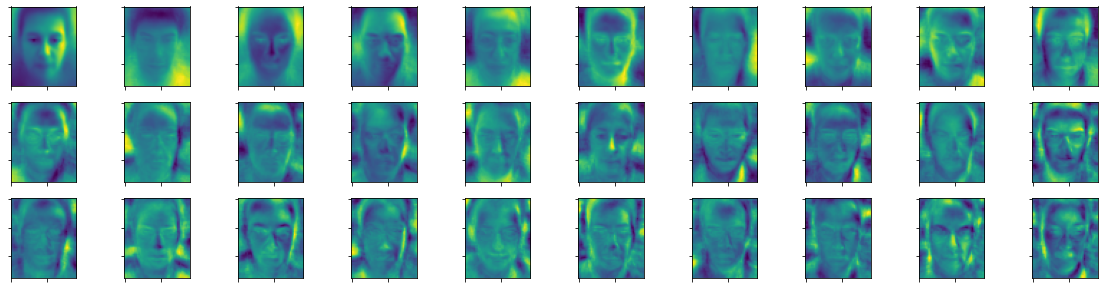

In [ ]:
### Top 30 Eigenfaces of high-D
_ , axes = plt.subplots(3, 10, figsize=(20, 5))
for i, ax in enumerate(axes.flat):
  ax.imshow(principal_components[:, i].reshape(46, 56).T)
  ax.set_yticklabels([])
  ax.set_xticklabels([])

###**Incremental PCA**

In [ ]:
number_of_partition = 4
partitions = []
for i in range(number_of_partition):
  temp = np.zeros((2576, 104))
  k = 0
  for j in range(0, n_samples, train_size):
    temp[:, k:k+2] = X_train[:, j+(i*2) : j+(i*2)+2]
    k += 2
  partitions.append(temp)